## Notebook 1: Regression of energy consumption

**1. Prepare Problem**

In [1]:
# a) Load libraries
import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np

import matplotlib.pyplot as plt

import xgboost as xgb
from tensorflow import keras
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from keras.layers import Reshape, Conv2D, BatchNormalization, Dropout, Dense, Flatten 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

from pickle import dump

import warnings
warnings.filterwarnings("ignore", message="pandas.Int64Index is deprecated")

D:\Software\Anaconda\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# b) Load dataset
# Load and view each file in the dataset
data = pd.read_csv('EPB_data.csv', header=0)
print(data.shape)
print(data.head(10))
print(data.dtypes)

(768, 10)
   Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   
5                  0.90         563.5      318.5     122.50             7.0   
6                  0.90         563.5      318.5     122.50             7.0   
7                  0.90         563.5      318.5     122.50             7.0   
8                  0.86         588.0      294.0     147.00             7.0   
9                  0.86         588.0      294.0     147.00             7.0   

   Orientation  Glazing Area  Glazing Area Distribution  Heating Load  \
0            2           0.0                   

One of the approach in optimizing building energy efficiency is to minimize total energy consumption, which is the sum of heating and cooling.

In [3]:
# Calculate total energy consumption by summing up heating and cooling loads
data['Energy Consumption'] = data[['Heating Load', 'Cooling Load']].sum(axis=1)
print(data.shape)

# Define features and label
X = data.drop(columns=['Heating Load', 'Cooling Load', 'Energy Consumption'], axis = 1)
y = data['Energy Consumption']

(768, 11)


**2. Dataset summary**

In [4]:
# a) Descriptive statistics
set_option("display.precision", 3)
print(data.describe())

       Relative Compactness  Surface Area  Wall Area  Roof Area  \
count               768.000       768.000    768.000    768.000   
mean                  0.764       671.708    318.500    176.604   
std                   0.106        88.086     43.626     45.166   
min                   0.620       514.500    245.000    110.250   
25%                   0.682       606.375    294.000    140.875   
50%                   0.750       673.750    318.500    183.750   
75%                   0.830       741.125    343.000    220.500   
max                   0.980       808.500    416.500    220.500   

       Overall Height  Orientation  Glazing Area  Glazing Area Distribution  \
count         768.000      768.000       768.000                    768.000   
mean            5.250        3.500         0.234                      2.812   
std             1.751        1.119         0.133                      1.551   
min             3.500        2.000         0.000                      0.000   
2

In [5]:
# checking categorical features
cat_features = data.select_dtypes(include='O').keys()
# display variabels
cat_features

Index([], dtype='object')

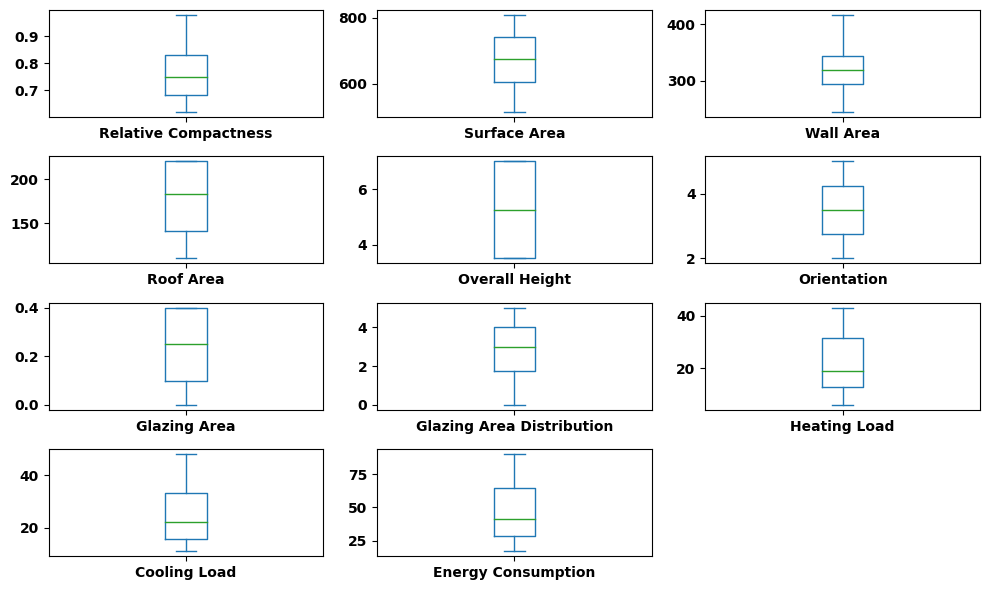

In [6]:
# b) Data visualizations
# Box and Whisker Plots of a few features

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

raw_plot = pd.DataFrame(data)
raw_plot.plot(kind='box', subplots=True, layout=(4,3), sharex=False, sharey=False)
plt.show()

We can see the data skewed to high values in relative compactness, roof area, glazing area, and cooling load.

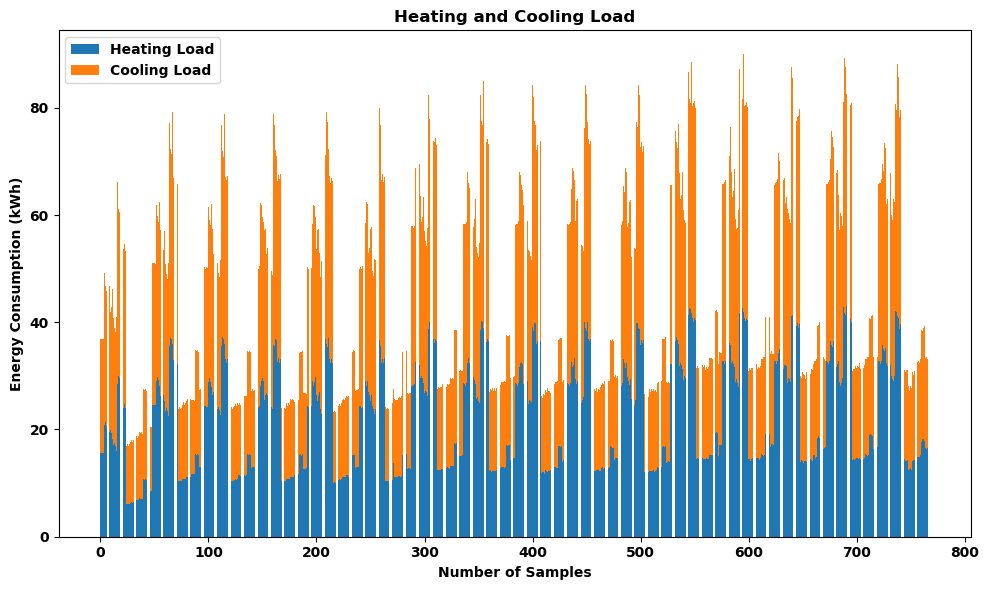

In [7]:
# create the stack bar chart of Heating and Cooling Load
fig, ax = plt.subplots()
ax.bar(np.arange(len(data['Heating Load'])), data['Heating Load'], label='Heating Load')
ax.bar(np.arange(len(data['Cooling Load'])), data['Cooling Load'], bottom=data['Heating Load'], label='Cooling Load')

# add labels, title and legend
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_title('Heating and Cooling Load')
ax.legend()

# show the plot
plt.show()

The data displays a cyclical pattern that may have resulted from the measurements taken on weekdays (with longer hours) and weekends.

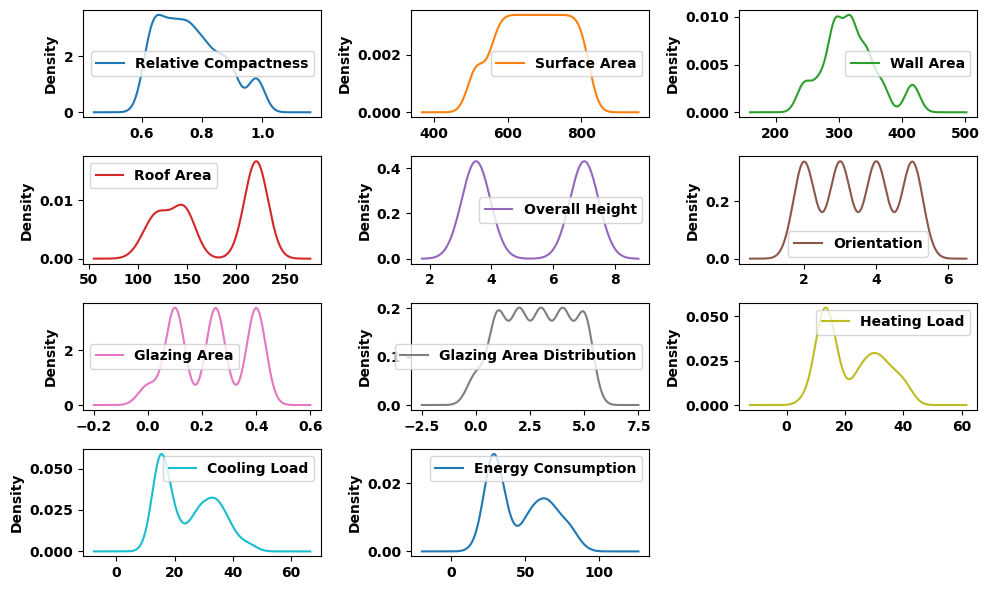

In [8]:
# Create density plots to check the Gaussian distribution of features
raw_plot.plot(kind='density', subplots=True, layout=(4,3), sharex=False)
plt.show()

The dataset seems to be complex as most of features exhibit non-Gaussian distributions, except for the Surface Area. There are several factors that could cause non-Gaussian distributions, including outliers, measurement errors, or the inherent characteristics of the building designs.

                           Relative Compactness  Surface Area  Wall Area  \
Relative Compactness                  1.000e+00    -9.919e-01 -2.038e-01   
Surface Area                         -9.919e-01     1.000e+00  1.955e-01   
Wall Area                            -2.038e-01     1.955e-01  1.000e+00   
Roof Area                            -8.688e-01     8.807e-01 -2.923e-01   
Overall Height                        8.277e-01    -8.581e-01  2.810e-01   
Orientation                           4.679e-17    -3.459e-17 -2.429e-17   
Glazing Area                         -2.961e-15     3.637e-15 -8.567e-17   
Glazing Area Distribution            -7.107e-16     2.438e-15  2.067e-16   
Heating Load                          6.223e-01    -6.581e-01  4.557e-01   
Cooling Load                          6.343e-01    -6.730e-01  4.271e-01   
Energy Consumption                    6.319e-01    -6.694e-01  4.445e-01   

                           Roof Area  Overall Height  Orientation  \
Relative Compactne

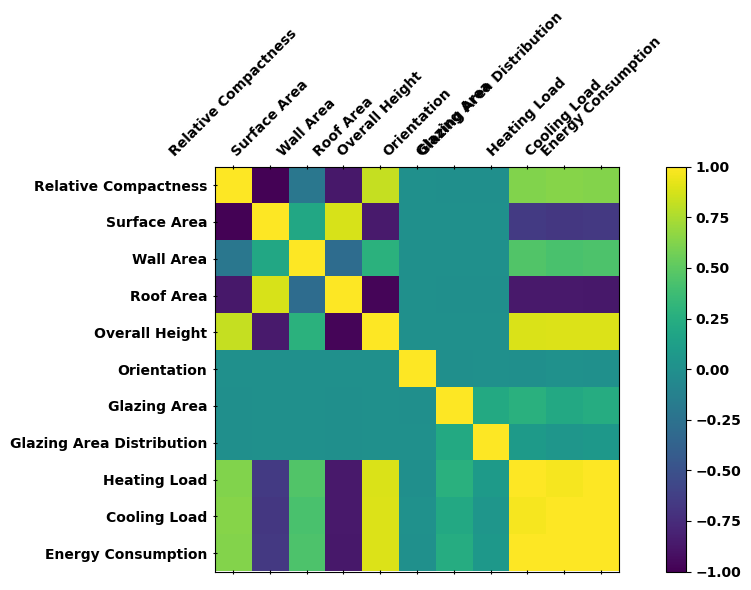

In [9]:
# correlation matrix between all pairs of attributes
print(data.corr(method='pearson'))
names = list(data)
fig = plt.figure()
sub_fig = fig.add_subplot(111)
cm = sub_fig.matshow(data.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cm)
sub_fig.tick_params(direction='inout')
sub_fig.set_xticks(np.arange(0,11))
sub_fig.set_yticks(np.arange(0,11))
sub_fig.set_xticklabels(names, rotation=45)
sub_fig.set_yticklabels(names)
plt.show()

According to the correlation matrix, the heating and cooling loads, as well as energy consumption, exhibit strong correlations with the overall height, orientation, and to some extent, the surface area. The orientation is considered to be an uncertain factor in building design due to limited choices compared to other variables and it plays a significant role in determining the energy efficiency of a building.

**3. Prepare Data**

In [10]:
# a) Data Cleaning
# summarize the number of unique values in each column
print(data.nunique())

Relative Compactness          12
Surface Area                  12
Wall Area                      7
Roof Area                      4
Overall Height                 2
Orientation                    4
Glazing Area                   4
Glazing Area Distribution      6
Heating Load                 586
Cooling Load                 636
Energy Consumption           700
dtype: int64


In [11]:
# Identify columns with missing values and count the number of missing values
data.columns[data.isnull().any()]
print(data.isnull().sum())

Relative Compactness         0
Surface Area                 0
Wall Area                    0
Roof Area                    0
Overall Height               0
Orientation                  0
Glazing Area                 0
Glazing Area Distribution    0
Heating Load                 0
Cooling Load                 0
Energy Consumption           0
dtype: int64


It is necessary to eliminate outliers in numerical data columns to improve the accuracy of training and validation processes. This can be done by determining the correlation between these columns and the target variable, identifying columns with low correlation, and then filtering out values that fall outside of the lower and upper bounds.

In [12]:
# calculate the correlation between numerical columns and target variable
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Energy Consumption']).sort_values(ascending=False)

# filter columns with low correlation 
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

In [13]:
# b) Split-out dataset into train and validation sets

X = data.drop(columns=['Heating Load', 'Cooling Load', 'Energy Consumption'], axis = 1)
y = data['Energy Consumption']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

# For XGBoost model
X_train1 = X_train
y_train1 = y_train
X_val1 = X_val

(537, 8) (537,) (231, 8) (231,)


In [14]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values 

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

**4. Evaluate Algorithms**

In [15]:
# a) Spot check algorithms using cross-validation technique
num_folds = 8
seed = 8

# Select 3 most popular algorithms for evaluation
models = []
models.append(('LR', LinearRegression()))
models.append(('RF', RandomForestRegressor()))

# Define the XGBoost model
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 1,
                max_depth = 5, alpha = 10, n_estimators = 10)
models.append(('XGB', model_xgb))

In [16]:
# Neural Network algorithms
# create keras Sequential model
def baseline_model():
    model = Sequential()
    model.add(Reshape((2, 4, 1), input_shape=(8,)))
    model.add(Conv2D(filters=32, kernel_size=(1, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Conv2D(filters=64, kernel_size=(1, 2), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer = 'adam',
                loss = 'mean_squared_error',
                metrics=['mse'])
    return model

# Build model
model_NN = baseline_model()
models.append(('NN', model_NN))

In [17]:
# Define a callback for early stopping if the validation loss does not improve for 10 consecutive 
# epochs (patience=20).
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [18]:
results = []
alg_names = []

# Initialize the KerasRegressor estimator with early stopping
estimator = KerasRegressor(model=model_NN, batch_size=128, verbose=1, callbacks=[early_stopping])

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    
    # modify loop for xgboost and NN
    if name != ('XGB' and 'NN'):
        cvs = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    else:    
        if name == 'NN':
            validation_data = (X_val, y_val)
            cvs = cross_val_score(estimator, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error', fit_params={'validation_data': validation_data, 'epochs': 50})
        else:
            # create DMatrix from training data for XGBoost
            dtrain = xgb.DMatrix(X_train1, label=y_train1)
            cvs = cross_val_score(model_xgb, X_train1, y_train1, cv=kfold, scoring='neg_mean_squared_error')
    
    results.append(cvs)
    alg_names.append(name)
    output = "%s: %f (%f)" % (name, cvs.mean(), cvs.std())
    print(output)

LR: -30.969344 (9.052568)
RF: -2.958016 (0.937559)
XGB: -2.775281 (0.646914)


INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmphteoot24\assets


INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmphteoot24\assets


Epoch 1/50
4/4 [==============================] - 1s 80ms/step - loss: 2457.6953 - mse: 2457.6953 - val_loss: 2747.3271 - val_mse: 2747.3271
Epoch 2/50
4/4 [==============================] - 0s 15ms/step - loss: 2323.1587 - mse: 2323.1587 - val_loss: 2738.4280 - val_mse: 2738.4280
Epoch 3/50
4/4 [==============================] - 0s 16ms/step - loss: 2177.8257 - mse: 2177.8257 - val_loss: 2725.1633 - val_mse: 2725.1633
Epoch 4/50
4/4 [==============================] - 0s 16ms/step - loss: 2027.7704 - mse: 2027.7704 - val_loss: 2706.9275 - val_mse: 2706.9275
Epoch 5/50
4/4 [==============================] - 0s 15ms/step - loss: 1853.0347 - mse: 1853.0347 - val_loss: 2682.6355 - val_mse: 2682.6355
Epoch 6/50
4/4 [==============================] - 0s 15ms/step - loss: 1667.1371 - mse: 1667.1371 - val_loss: 2651.2878 - val_mse: 2651.2878
Epoch 7/50
4/4 [==============================] - 0s 15ms/step - loss: 1467.4437 - mse: 1467.4437 - val_loss: 2612.5667 - val_mse: 2612.5667
Epoch 8/50
4/

INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmptzh02hfz\assets


INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmptzh02hfz\assets


Epoch 1/50
4/4 [==============================] - 1s 92ms/step - loss: 2446.4714 - mse: 2446.4714 - val_loss: 2747.0901 - val_mse: 2747.0901
Epoch 2/50
4/4 [==============================] - 0s 13ms/step - loss: 2306.1133 - mse: 2306.1133 - val_loss: 2737.9382 - val_mse: 2737.9382
Epoch 3/50
4/4 [==============================] - 0s 13ms/step - loss: 2168.2725 - mse: 2168.2725 - val_loss: 2724.2808 - val_mse: 2724.2808
Epoch 4/50
4/4 [==============================] - 0s 15ms/step - loss: 2011.7601 - mse: 2011.7601 - val_loss: 2705.1143 - val_mse: 2705.1143
Epoch 5/50
4/4 [==============================] - 0s 13ms/step - loss: 1839.0580 - mse: 1839.0580 - val_loss: 2680.2683 - val_mse: 2680.2683
Epoch 6/50
4/4 [==============================] - 0s 14ms/step - loss: 1678.8615 - mse: 1678.8615 - val_loss: 2648.4819 - val_mse: 2648.4819
Epoch 7/50
4/4 [==============================] - 0s 13ms/step - loss: 1462.9097 - mse: 1462.9097 - val_loss: 2608.8120 - val_mse: 2608.8120
Epoch 8/50
4/

INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmp36cb633o\assets


INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmp36cb633o\assets


Epoch 1/50
4/4 [==============================] - 1s 76ms/step - loss: 2408.2510 - mse: 2408.2510 - val_loss: 2747.3616 - val_mse: 2747.3616
Epoch 2/50
4/4 [==============================] - 0s 14ms/step - loss: 2270.3850 - mse: 2270.3850 - val_loss: 2738.3894 - val_mse: 2738.3894
Epoch 3/50
4/4 [==============================] - 0s 14ms/step - loss: 2115.5271 - mse: 2115.5271 - val_loss: 2725.4729 - val_mse: 2725.4729
Epoch 4/50
4/4 [==============================] - 0s 15ms/step - loss: 1958.5713 - mse: 1958.5713 - val_loss: 2707.0422 - val_mse: 2707.0422
Epoch 5/50
4/4 [==============================] - 0s 14ms/step - loss: 1807.5442 - mse: 1807.5442 - val_loss: 2683.1819 - val_mse: 2683.1819
Epoch 6/50
4/4 [==============================] - 0s 14ms/step - loss: 1625.5510 - mse: 1625.5510 - val_loss: 2652.3560 - val_mse: 2652.3560
Epoch 7/50
4/4 [==============================] - 0s 15ms/step - loss: 1428.4459 - mse: 1428.4459 - val_loss: 2613.9292 - val_mse: 2613.9292
Epoch 8/50
4/

INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmp7p5e448q\assets


INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmp7p5e448q\assets


Epoch 1/50
4/4 [==============================] - 1s 76ms/step - loss: 2509.6079 - mse: 2509.6079 - val_loss: 2747.6919 - val_mse: 2747.6919
Epoch 2/50
4/4 [==============================] - 0s 14ms/step - loss: 2355.8679 - mse: 2355.8679 - val_loss: 2738.5474 - val_mse: 2738.5474
Epoch 3/50
4/4 [==============================] - 0s 14ms/step - loss: 2201.0156 - mse: 2201.0156 - val_loss: 2724.4839 - val_mse: 2724.4839
Epoch 4/50
4/4 [==============================] - 0s 14ms/step - loss: 2052.0449 - mse: 2052.0449 - val_loss: 2704.8352 - val_mse: 2704.8352
Epoch 5/50
4/4 [==============================] - 0s 14ms/step - loss: 1882.8292 - mse: 1882.8292 - val_loss: 2679.2136 - val_mse: 2679.2136
Epoch 6/50
4/4 [==============================] - 0s 14ms/step - loss: 1683.1741 - mse: 1683.1741 - val_loss: 2647.0823 - val_mse: 2647.0823
Epoch 7/50
4/4 [==============================] - 0s 16ms/step - loss: 1498.2678 - mse: 1498.2678 - val_loss: 2607.0173 - val_mse: 2607.0173
Epoch 8/50
4/

INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmpq_jxo1eq\assets


INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmpq_jxo1eq\assets


Epoch 1/50
4/4 [==============================] - 1s 79ms/step - loss: 2477.3777 - mse: 2477.3777 - val_loss: 2745.9204 - val_mse: 2745.9204
Epoch 2/50
4/4 [==============================] - 0s 14ms/step - loss: 2338.2988 - mse: 2338.2988 - val_loss: 2736.8972 - val_mse: 2736.8972
Epoch 3/50
4/4 [==============================] - 0s 14ms/step - loss: 2188.4626 - mse: 2188.4626 - val_loss: 2724.1299 - val_mse: 2724.1299
Epoch 4/50
4/4 [==============================] - 0s 13ms/step - loss: 2045.1304 - mse: 2045.1304 - val_loss: 2705.4680 - val_mse: 2705.4680
Epoch 5/50
4/4 [==============================] - 0s 14ms/step - loss: 1864.5148 - mse: 1864.5148 - val_loss: 2680.2732 - val_mse: 2680.2732
Epoch 6/50
4/4 [==============================] - 0s 13ms/step - loss: 1680.1588 - mse: 1680.1588 - val_loss: 2647.9839 - val_mse: 2647.9839
Epoch 7/50
4/4 [==============================] - 0s 15ms/step - loss: 1471.6132 - mse: 1471.6132 - val_loss: 2607.1472 - val_mse: 2607.1472
Epoch 8/50
4/

1/1 [==============================] - 0s 102ms/step


INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmp0m5q8vkh\assets


INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmp0m5q8vkh\assets


Epoch 1/50
4/4 [==============================] - 1s 77ms/step - loss: 2464.5984 - mse: 2464.5984 - val_loss: 2747.1855 - val_mse: 2747.1855
Epoch 2/50
4/4 [==============================] - 0s 14ms/step - loss: 2324.0081 - mse: 2324.0081 - val_loss: 2737.7402 - val_mse: 2737.7402
Epoch 3/50
4/4 [==============================] - 0s 14ms/step - loss: 2157.9646 - mse: 2157.9646 - val_loss: 2723.9221 - val_mse: 2723.9221
Epoch 4/50
4/4 [==============================] - 0s 14ms/step - loss: 1995.0309 - mse: 1995.0309 - val_loss: 2705.2310 - val_mse: 2705.2310
Epoch 5/50
4/4 [==============================] - 0s 15ms/step - loss: 1835.0099 - mse: 1835.0099 - val_loss: 2680.4734 - val_mse: 2680.4734
Epoch 6/50
4/4 [==============================] - 0s 14ms/step - loss: 1644.0199 - mse: 1644.0199 - val_loss: 2649.2910 - val_mse: 2649.2910
Epoch 7/50
4/4 [==============================] - 0s 14ms/step - loss: 1445.7694 - mse: 1445.7694 - val_loss: 2610.8469 - val_mse: 2610.8469
Epoch 8/50
4/

1/1 [==============================] - 0s 112ms/step


INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmphagcjusi\assets


INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmphagcjusi\assets


Epoch 1/50
4/4 [==============================] - 1s 86ms/step - loss: 2386.8518 - mse: 2386.8518 - val_loss: 2746.8911 - val_mse: 2746.8911
Epoch 2/50
4/4 [==============================] - 0s 14ms/step - loss: 2258.3801 - mse: 2258.3801 - val_loss: 2737.5171 - val_mse: 2737.5171
Epoch 3/50
4/4 [==============================] - 0s 14ms/step - loss: 2123.2178 - mse: 2123.2178 - val_loss: 2723.9104 - val_mse: 2723.9104
Epoch 4/50
4/4 [==============================] - 0s 15ms/step - loss: 1974.2460 - mse: 1974.2460 - val_loss: 2705.2539 - val_mse: 2705.2539
Epoch 5/50
4/4 [==============================] - 0s 16ms/step - loss: 1828.3824 - mse: 1828.3824 - val_loss: 2680.9785 - val_mse: 2680.9785
Epoch 6/50
4/4 [==============================] - 0s 13ms/step - loss: 1636.5848 - mse: 1636.5848 - val_loss: 2649.8511 - val_mse: 2649.8511
Epoch 7/50
4/4 [==============================] - 0s 14ms/step - loss: 1469.2485 - mse: 1469.2485 - val_loss: 2610.8567 - val_mse: 2610.8567
Epoch 8/50
4/

INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmpjw7_h9qt\assets


INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmpjw7_h9qt\assets


Epoch 1/50
4/4 [==============================] - 1s 75ms/step - loss: 2482.2012 - mse: 2482.2012 - val_loss: 2747.4194 - val_mse: 2747.4194
Epoch 2/50
4/4 [==============================] - 0s 15ms/step - loss: 2336.1169 - mse: 2336.1169 - val_loss: 2737.9124 - val_mse: 2737.9124
Epoch 3/50
4/4 [==============================] - 0s 14ms/step - loss: 2186.4153 - mse: 2186.4153 - val_loss: 2724.4480 - val_mse: 2724.4480
Epoch 4/50
4/4 [==============================] - 0s 14ms/step - loss: 2051.6204 - mse: 2051.6204 - val_loss: 2705.6418 - val_mse: 2705.6418
Epoch 5/50
4/4 [==============================] - 0s 16ms/step - loss: 1867.9073 - mse: 1867.9073 - val_loss: 2681.1274 - val_mse: 2681.1274
Epoch 6/50
4/4 [==============================] - 0s 15ms/step - loss: 1675.8691 - mse: 1675.8691 - val_loss: 2649.7905 - val_mse: 2649.7905
Epoch 7/50
4/4 [==============================] - 0s 15ms/step - loss: 1478.3351 - mse: 1478.3351 - val_loss: 2610.7847 - val_mse: 2610.7847
Epoch 8/50
4/

Epoch 1/500
5/5 [==============================] - 1s 55ms/step - loss: 2443.4741 - mse: 2443.4741 - val_loss: 2745.9583 - val_mse: 2745.9583
Epoch 2/500
5/5 [==============================] - 0s 11ms/step - loss: 2268.8850 - mse: 2268.8850 - val_loss: 2733.5901 - val_mse: 2733.5901
Epoch 3/500
5/5 [==============================] - 0s 12ms/step - loss: 2095.1514 - mse: 2095.1514 - val_loss: 2713.7808 - val_mse: 2713.7808
Epoch 4/500
5/5 [==============================] - 0s 12ms/step - loss: 1908.8723 - mse: 1908.8723 - val_loss: 2685.0432 - val_mse: 2685.0432
Epoch 5/500
5/5 [==============================] - 0s 11ms/step - loss: 1688.0215 - mse: 1688.0215 - val_loss: 2647.0286 - val_mse: 2647.0286
Epoch 6/500
5/5 [==============================] - 0s 10ms/step - loss: 1468.6624 - mse: 1468.6624 - val_loss: 2596.3052 - val_mse: 2596.3052
Epoch 7/500
5/5 [==============================] - 0s 12ms/step - loss: 1205.6041 - mse: 1205.6041 - val_loss: 2530.8076 - val_mse: 2530.8076
Epoch 

5/5 [==============================] - 0s 13ms/step - loss: 51.3797 - mse: 51.3797 - val_loss: 190.4530 - val_mse: 190.4530
Epoch 61/500
5/5 [==============================] - 0s 11ms/step - loss: 48.3699 - mse: 48.3699 - val_loss: 185.5683 - val_mse: 185.5683
Epoch 62/500
5/5 [==============================] - 0s 12ms/step - loss: 48.8078 - mse: 48.8078 - val_loss: 176.8469 - val_mse: 176.8469
Epoch 63/500
5/5 [==============================] - 0s 11ms/step - loss: 46.8453 - mse: 46.8453 - val_loss: 166.3992 - val_mse: 166.3992
Epoch 64/500
5/5 [==============================] - 0s 11ms/step - loss: 49.6301 - mse: 49.6301 - val_loss: 162.0445 - val_mse: 162.0445
Epoch 65/500
5/5 [==============================] - 0s 11ms/step - loss: 49.8589 - mse: 49.8589 - val_loss: 154.4388 - val_mse: 154.4388
Epoch 66/500
5/5 [==============================] - 0s 11ms/step - loss: 51.0836 - mse: 51.0836 - val_loss: 145.8211 - val_mse: 145.8211
Epoch 67/500
5/5 [==============================] - 0s

5/5 [==============================] - 0s 12ms/step - loss: 42.6175 - mse: 42.6175 - val_loss: 27.1625 - val_mse: 27.1625
Epoch 121/500
5/5 [==============================] - 0s 12ms/step - loss: 33.9246 - mse: 33.9246 - val_loss: 26.8879 - val_mse: 26.8879
Epoch 122/500
5/5 [==============================] - 0s 12ms/step - loss: 35.7637 - mse: 35.7637 - val_loss: 26.3626 - val_mse: 26.3626
Epoch 123/500
5/5 [==============================] - 0s 11ms/step - loss: 34.3533 - mse: 34.3533 - val_loss: 26.4483 - val_mse: 26.4483
Epoch 124/500
5/5 [==============================] - 0s 11ms/step - loss: 38.0194 - mse: 38.0194 - val_loss: 26.4202 - val_mse: 26.4202
Epoch 125/500
5/5 [==============================] - 0s 11ms/step - loss: 36.5464 - mse: 36.5464 - val_loss: 26.4436 - val_mse: 26.4436
Epoch 126/500
5/5 [==============================] - 0s 11ms/step - loss: 35.2383 - mse: 35.2383 - val_loss: 26.6999 - val_mse: 26.6999
Epoch 127/500
5/5 [==============================] - 0s 12ms/s

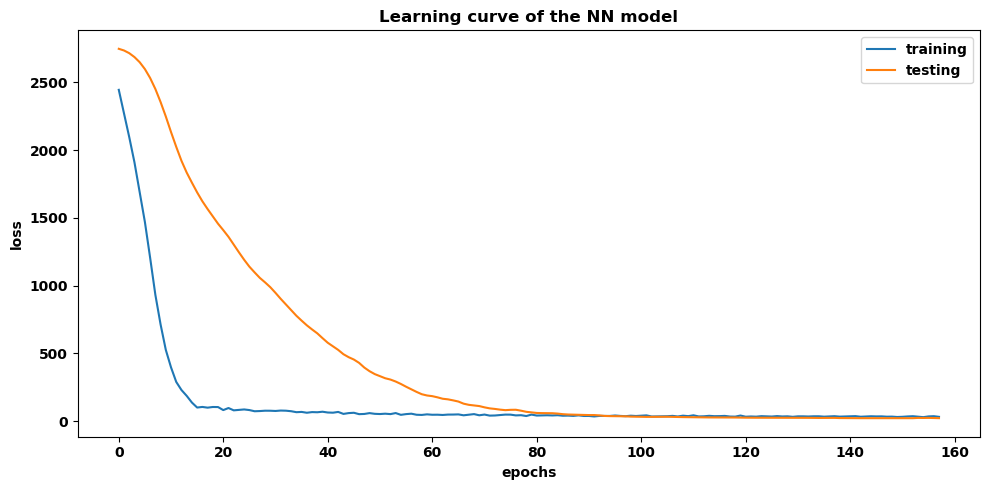

In [19]:
# Plot learning curve of NN model
history = model_NN.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=128, callbacks=[early_stopping])

plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'], label = 'training')
plt.plot(history.history['val_loss'], label = 'testing')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Learning curve of the NN model')
plt.legend()

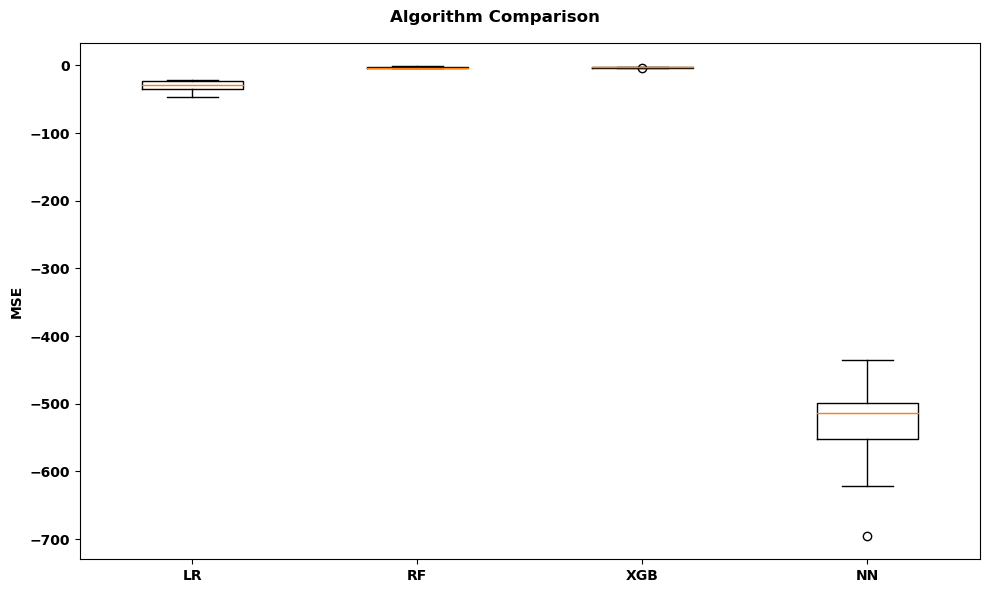

In [20]:
# b) Compare algorithms and the NN model
# Distribution of accuracy values calculated across 8 cross-validation folds.
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot()
plt.boxplot(results)
ax.set_xticklabels(alg_names)
plt.ylabel("MSE")
plt.show()

Of the three algorithms and NN model, the ensemble models outperformed Linear Regression and NN model.

In a regression problem, it is common to use the mean error as a measure of validation. This is done by first calculating the mean absolute error (MAE) of the test data with the mean of dataset, and then calculating the MAE of the test data with the predicted data. 

In [21]:
# Evaluate performance of Random Forest algorithm on validation data
model_RF = RandomForestRegressor(n_estimators=10)
model_RF.fit(X_train, y_train)
y_pred_RF = model_RF.predict(X_val)
mae_pred_RF = mean_absolute_error(y_val, y_pred_RF)
print("Mean Absolute Error of predicted data: ", mae_pred_RF)

Mean Absolute Error of predicted data:  1.2572467532467537


In [22]:
# Evaluate performance of XGBoost algorithm on validation data
model_xgb.fit(X_train1, y_train1)
dtrain = xgb.DMatrix(X_val1)
y_pred_xgb = model_xgb.predict(X_val1)
mae_pred_xgb = mean_absolute_error(y_val, y_pred_xgb)
print("Mean Absolute Error of predicted data: ", mae_pred_xgb)

Mean Absolute Error of predicted data:  1.412210528551242


In [23]:
# Define baseline mean_absolute_error of y_val in the data set
y_mean = np.mean(y)
y_mean = np.array([y_mean]*len(y_val))
mae_ori = mean_absolute_error(y_val, y_mean)
print("Mean Absolute Error of original data: ", mae_ori)

Mean Absolute Error of original data:  17.70811874323593


The resulting MAE values show that Random Forest looks better than XGBoost in prediction performance. For the sake of simplicity, I selected Random Forest as the surrogate model for the optimization process in the 2nd Notebook.

**5. Finalize Model**

In [24]:
# a) Get best model parameters
model_params = model_RF.get_params()

# Print the model's parameters
print(model_params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


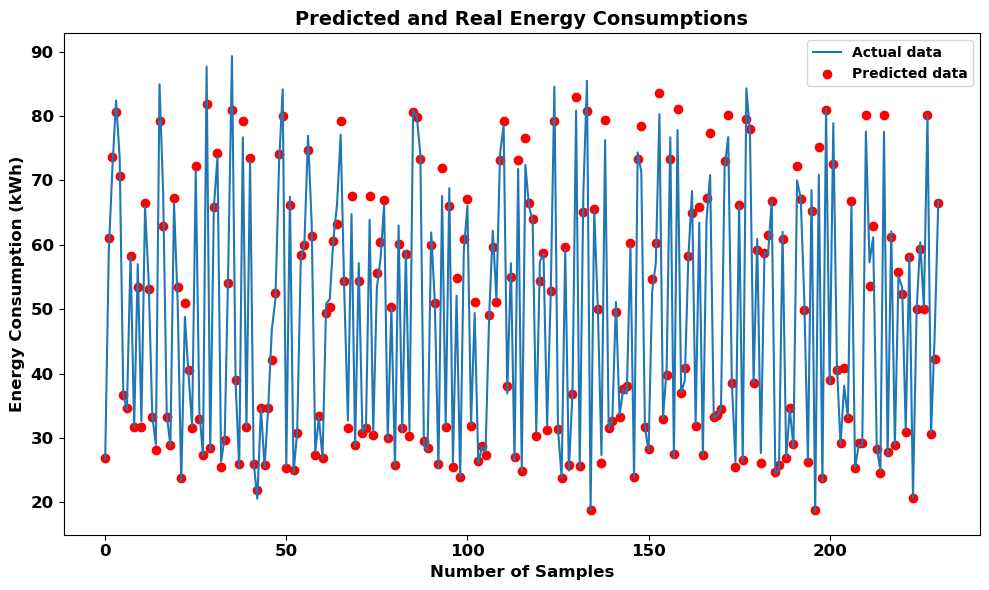

In [25]:
fig, ax = plt.subplots()

# Plot the actual data as a line chart
ax.plot(range(len(y_val)), y_val, label='Actual data')

# Overlay the predicted data as a scatter plot
ax.scatter(range(len(y_pred_RF)), y_pred_RF, label='Predicted data', color='red')

# Add labels, title, and legend
ax.set_xlabel('Number of Samples', fontsize=12)
ax.set_ylabel('Energy Consumption (kWh)', fontsize=12)
ax.set_title('Predicted and Real Energy Consumptions', fontsize=14)
ax.legend()

# set tick font size for both axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

In [26]:
# b) Save model for later use
# save the model to disk
filename = 'finalized_model.sav'
dump(model_RF, open(filename, 'wb'))

**6. Conclusions**

- Exploratory data analysis shows that most input variables exhibit non-Gaussian distribution.

- Among the three machine learning algorithms and neural network (NN) model, Random Forest and XGBoost attained lowest Mean Squared Error values following cross validation process. The Random Forest algorithm was selected as the surrogate model for optimization process in the 2nd Notebook.

- The Mean Absolute Error values indicate that the prediction accuracy for the ensemble algorithms is excellent, whereas it was unexpectedly low for the NN model.

- The performance of the NN model (Keras Sequential) is worst than all ML algorithms. Further tunning of the hyperparameter may yield a better prediction score.